In [1]:
# Параметры скрипта
#TRAIN_HEAD_ONLY = False  # Выключать ли обучение всего, кроме головы сети
MAX_EPOCH = 200  # Ограничение на число эпох, если не сработала ранняя остановка
BATCH_SIZE = 32  # Фактический размер батча
#TOTAL_BATCH_SIZE = 32  # Если мало памяти в GPU, то можно использовать gradient accumulation и добить до этого размера
#ACCUMULATION_STEPS = (TOTAL_BATCH_SIZE + BATCH_SIZE - 1) // BATCH_SIZE
#LOG = True  # Вести ли журнал
#SAVE_SNAPSHOTS = False  # Сохранять ли модель каждую эпоху
#RANDOM_SEED = 0 # None - не фиксировать

NUM_CLASSES = 2

TRAIN_DIR = r'/srv/fast1/y.pchelitsev/datasets/chest-x-ray/sakha-tb/Sakha-TB-8bit/Train'
VAL_DIR = r'/srv/fast1/y.pchelitsev/datasets/chest-x-ray/sakha-tb/Sakha-TB-8bit/Val'
TEST_DIR = r'/srv/fast1/y.pchelitsev/datasets/chest-x-ray/sakha-tb/Sakha-TB-8bit/Test'

#SAVE_PATH = 'trained_model'

#NUM_WORKERS = 3 # 0 ~ делать всё в главном процессе; -1 ~ CPU core num; НЕ БОЛЬШЕ 4-х!

In [2]:
# Так много импортов не нужно, многое есть в covid19base, но пусть будет на случай, если понадобится написать что-то
import collections.abc
import copy
import datetime
import imageio
import importlib
import itertools
import json
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import PIL
import random
import scipy.stats
import shutil
import skimage
import skimage.filters
import sklearn
import sklearn.base
import sklearn.exceptions
import sklearn.metrics
import sys
import time
import torch
import torch.nn
import torch.optim
import torchvision
import tqdm
import tqdm.auto
import tqdm.notebook
import warnings
import pytorch_lightning as pl
import model_lit
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

In [3]:
IMG_EXT = [x[1:] for x in torchvision.datasets.folder.IMG_EXTENSIONS] # Ибо такие типы собирает ImageFolder
IMG_EXT

['jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp']

In [4]:
pl.IMG_EXT = IMG_EXT
#!nvidia-smi

Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/m.kuleshova/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Co

Sanity Checking: |                                                                                | 0/? [00:00…

/home/m.kuleshova/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/m.kuleshova/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/m.kuleshova/.local/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved. New best score: 0.666


Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.617


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.611


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.610


Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.605


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.605


Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.602


Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.596


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.593


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.592


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.592. Signaling Trainer to stop.


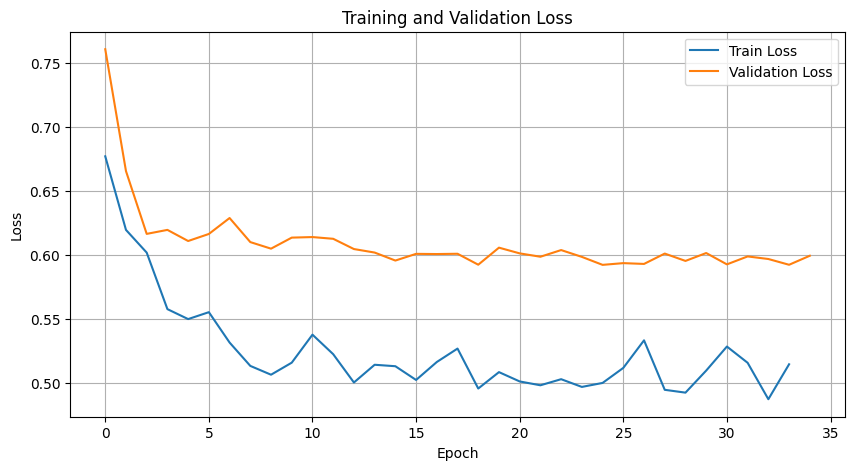

In [5]:
from model_lit import COVIDModel
from model_lit import DataModule
from model_lit import early_stop_callback
input_hwc = (512, 512, 3)

data_module = DataModule(train_dir=TRAIN_DIR, val_dir=VAL_DIR, test_dir=TEST_DIR, batch_size=BATCH_SIZE)
model = COVIDModel(num_classes=NUM_CLASSES, freeze_encoder=True)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCH,
    callbacks=[early_stop_callback],
    logger=True,
    enable_progress_bar=True
)
trainer.fit(model, datamodule=data_module)

In [6]:
print('Done!')
print(f"Финальное значение функции потерь на валидации: {trainer.callback_metrics['val_loss'].item():.4f}")
print(f"Финальная точность на валидации: {trainer.callback_metrics['val_acc'].item():.4f}")

Done!
Финальное значение функции потерь на валидации: 0.5995
Финальная точность на валидации: 0.7077
